# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [164]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [165]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: вероятно, это вероятности принадлежности объектов к положительному классу

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [166]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


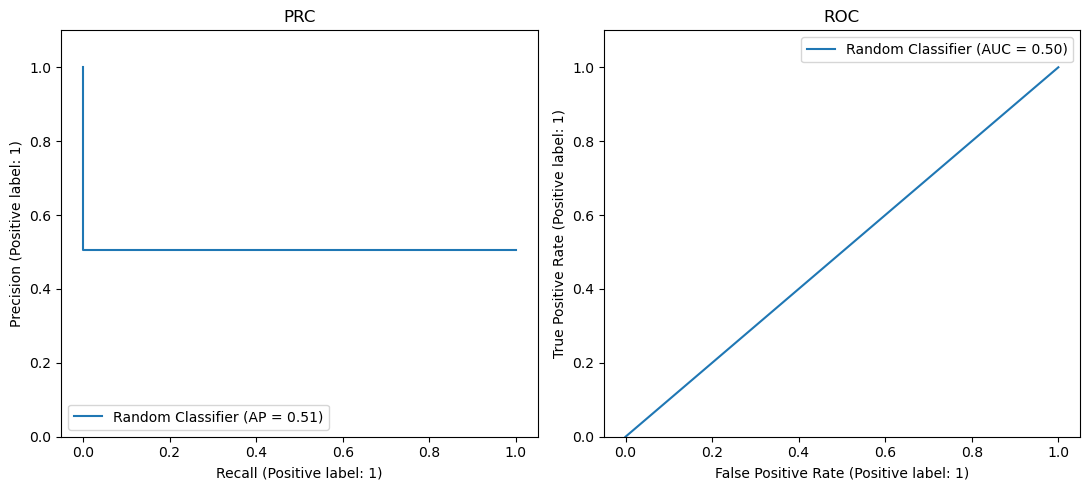

In [167]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [168]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [169]:
#your code here
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import LinearSVC
auc_pr = []
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
parameters = [10**x for x in range(-4, 3)]
for i in parameters:
    model = LinearSVC(C = i)
    model.fit(X_train, y_train)
    y_res = model.decision_function(X_val)
    precision, recall, _ = precision_recall_curve(y_val, y_res)
    auc_pr.append(auc(recall, precision))
max_value = max(auc_pr)
best_C = parameters[auc_pr.index(max_value)]
print("Best_C = ", best_C)

Best_C =  10


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

SVM metrics
AUC-PR: 0.83681
AUC-ROC: 0.84281


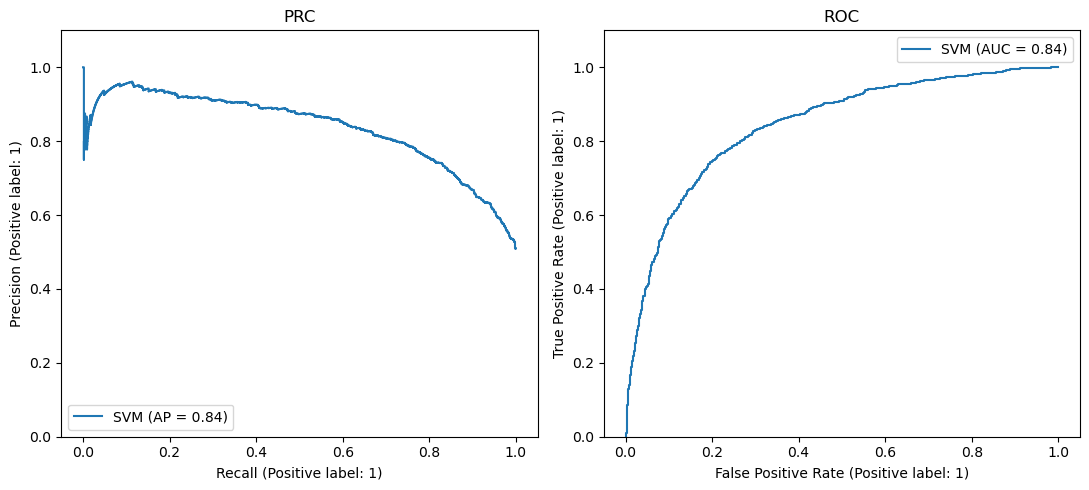

In [170]:
#your code here
model_svm = LinearSVC(C = best_C)
model_svm.fit(X_train, y_train)
y_svm = model_svm.decision_function(X_test)
depict_pr_roc(y_test, y_svm, 'SVM')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [171]:
#your code here
precision, recall, _ = precision_recall_curve(y_test, y_svm)
df_metrics.loc['SVM'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_svm),
      0
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0
SVM,0.836808,0.842811,0.0


Мы видим значительное улучшение результатов по сравнению со случайным классификатором.

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [172]:
#your code here
from sklearn.linear_model import LogisticRegression
np.random.seed(42)
auc_pr = []
parameters = [10**x for x in range(-4, 3)]
for i in parameters:
    model = LogisticRegression(penalty = 'l2', C = i)
    model.fit(X_train, y_train)
    y_res = model.decision_function(X_val)
    precision, recall, _ = precision_recall_curve(y_val, y_res)
    auc_pr.append(auc(recall, precision))
max_value = max(auc_pr)
best_C_lr = parameters[auc_pr.index(max_value)]
print("Best_C = ", best_C_lr)

Best_C =  0.0001


LR metrics
AUC-PR: 0.82939
AUC-ROC: 0.83340


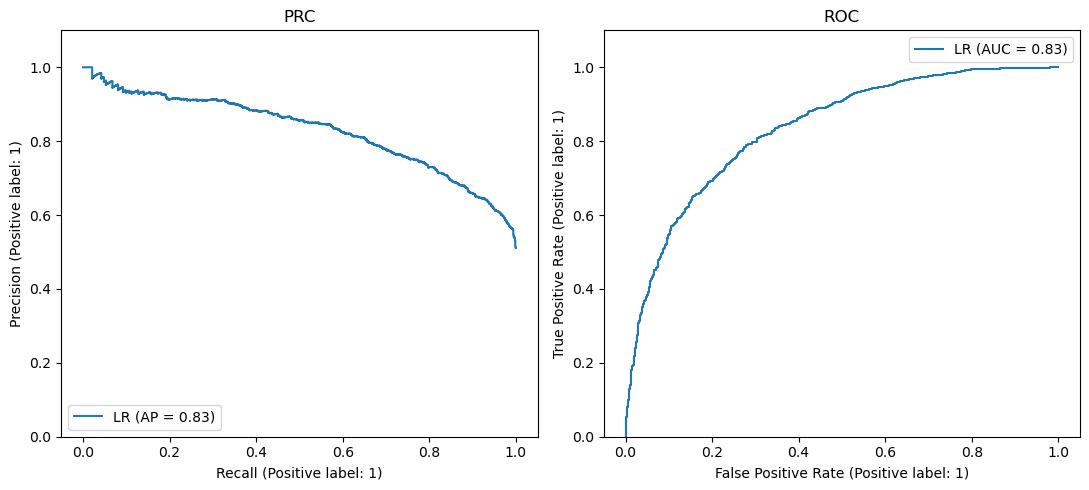

In [173]:
model_lr = LogisticRegression(penalty = 'l2', C = best_C_lr)
model_lr.fit(X_train, y_train)
y_lr = model_lr.decision_function(X_test)
depict_pr_roc(y_test, y_lr, 'LR')

In [174]:
precision, recall, _ = precision_recall_curve(y_test, y_lr)
df_metrics.loc['LR'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_lr),
      0
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0
SVM,0.836808,0.842811,0.0
LR,0.829392,0.833400,0.0


Снова видим значительное улучшение качества по сравнению со случайным классификатором. 

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

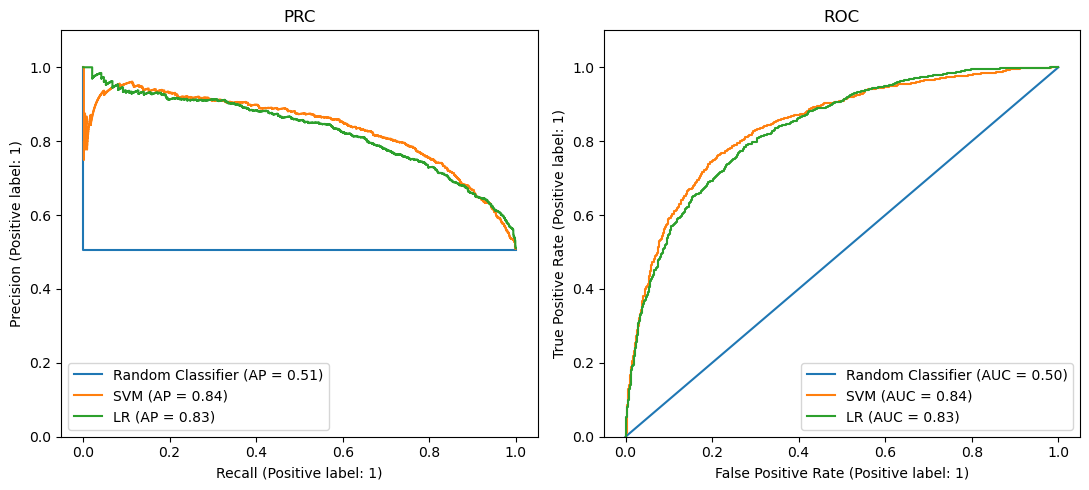

In [175]:
#your code here
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0], name='Random Classifier')
PrecisionRecallDisplay.from_predictions(y_test, y_svm, ax=ax[0], name='SVM')
PrecisionRecallDisplay.from_predictions(y_test, y_lr, ax=ax[0], name='LR')  
#   precision, recall, _ = precision_recall_curve(y_true, y_pred)
#   print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1], name='Random Classifier')
RocCurveDisplay.from_predictions(y_test, y_svm, ax=ax[1], name='SVM')
RocCurveDisplay.from_predictions(y_test, y_lr, ax=ax[1], name='LR')   
  #print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
ax[1].set_title("ROC")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.legend()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:*  Можно заметить, что результаты SVM и LR практически не отличаются. Эти методы имеют примерно одинаковые значения AUC-ROC и AUC-PRC. Также формы этих кривых очень похожи.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [176]:
#your code here
from sklearn.datasets import make_classification
from sklearn.svm import SVC
np.random.seed(42)
X, y = make_classification(n_samples=1000, n_features=2, 
                           n_classes=2, 
                           n_informative=2, n_redundant=0, 
                           n_repeated=0, 
                           shuffle=True, random_state=42)
SVM = SVC(kernel='linear').fit(X, y)

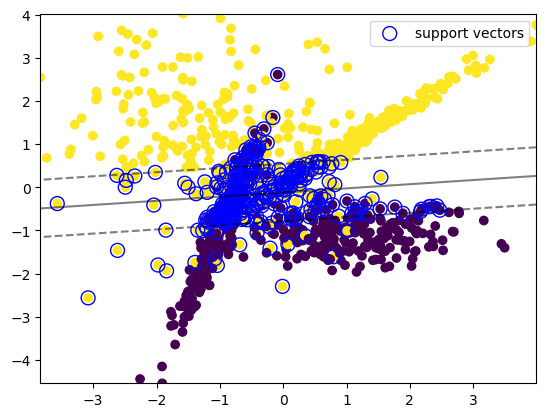

In [177]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape) #your code here

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(#your code here
                X[:, 0], X[:, 1], c = y)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(#your code here
                   model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, SVM)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** #your answer here

Идея метода опорных векторов состоит в том, что подобраются веса так, чтобы объукты классов лежали как можно дальше от разделяющей гиперплоскости, то есть максимизируем отступ между гиперплоскостью и объектами, которые расположены к ней ближе всего. Эти объекты и есть опорные векторы.  

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [178]:
lin_reg = LogisticRegression().fit(X, y)

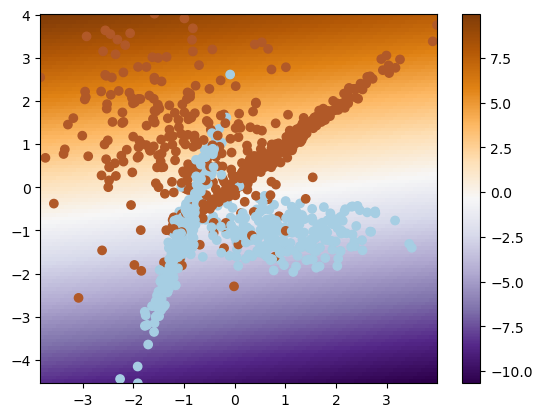

In [179]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.decision_function(xy)#your code here
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c = y, #your code here
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, lin_reg)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** #your answer here

Вероятно, на картинке это область, которая выделена пактически белым цветом. В этом месте отступ равен 0, то есть объекты лежат на гиперплоскости (модель не знает, куда их отнести),  если мы будем брать сигмоиду от нулевого отступа, как раз получим вероятность 0,5.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [180]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((r + l) / 2)
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)] == 1)/len(y_test[(preds >= l) & (preds < r)]))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot(bin_middle_points, bin_middle_points) #добавим диагональ
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [181]:
#your code here
np.random.seed(42)
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [182]:
svc = LinearSVC(max_iter=100000, C=0.1).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
lr = LogisticRegression(max_iter=100000, C=0.1).fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]

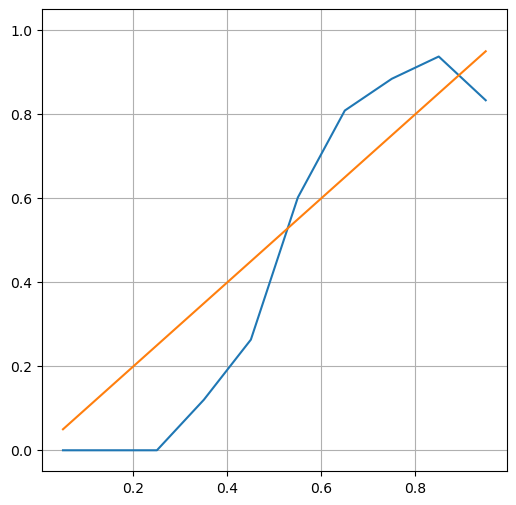

In [183]:
plot_calibration_curve(y_test, svc_pred)

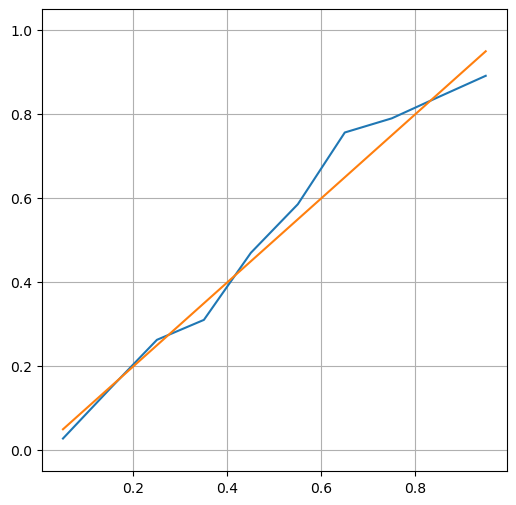

In [184]:
plot_calibration_curve(y_test, lr_pred)

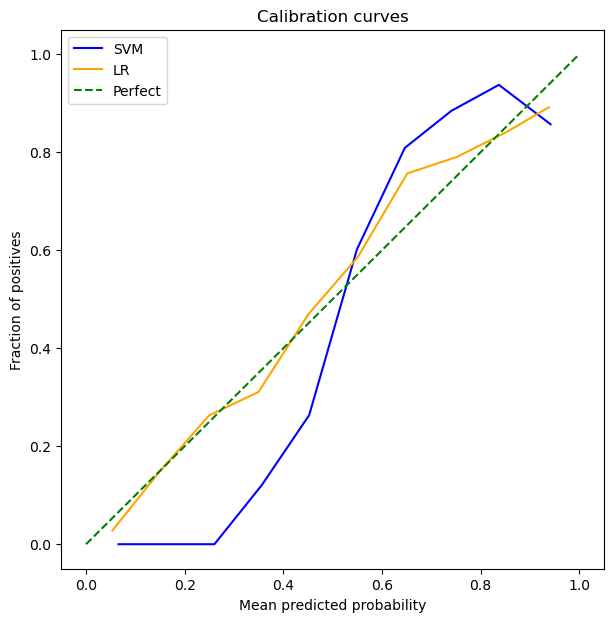

In [185]:
#построим аналогичный график
from sklearn.calibration import calibration_curve
plt.figure(figsize=(7, 7))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=10)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, lr_pred, n_bins=10)

plt.plot(svc_pred_prob, svc_true_prob, label='SVM', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** #your answer here

Для логистической регрессии кривая откалибрована достаточно хорошо, она близка к диагонали. Для SVM откалибрована плохо.

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

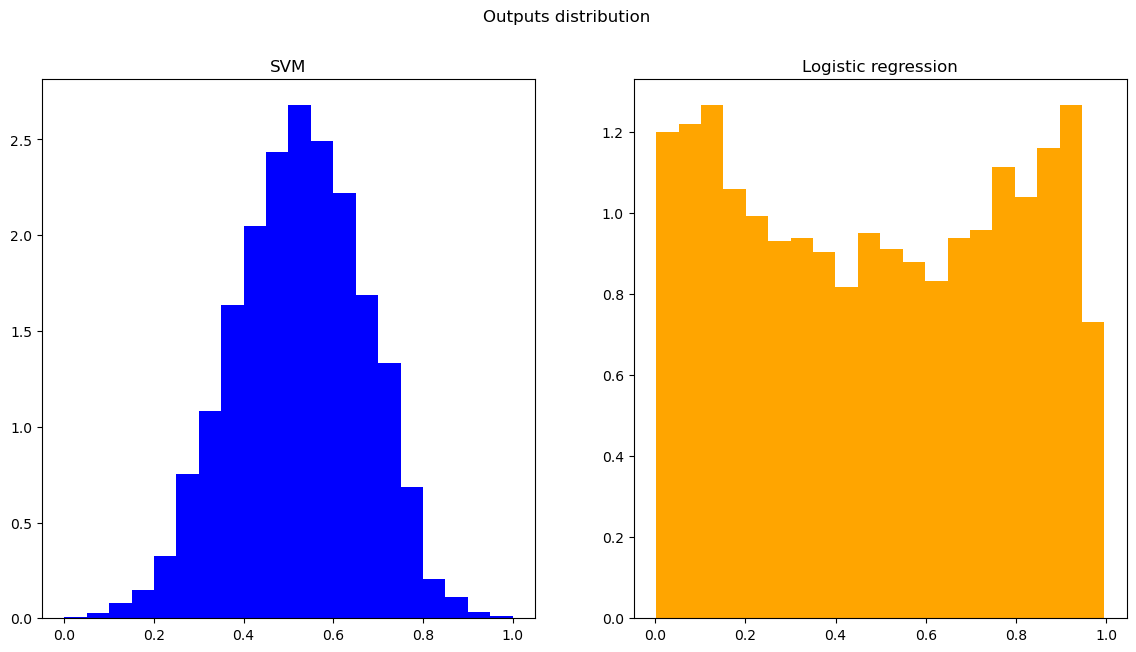

In [186]:
#посмотрим на распределение вероятностей
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(lr_pred, bins=20, color='orange', density='True')

axs[0].set_title('SVM')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

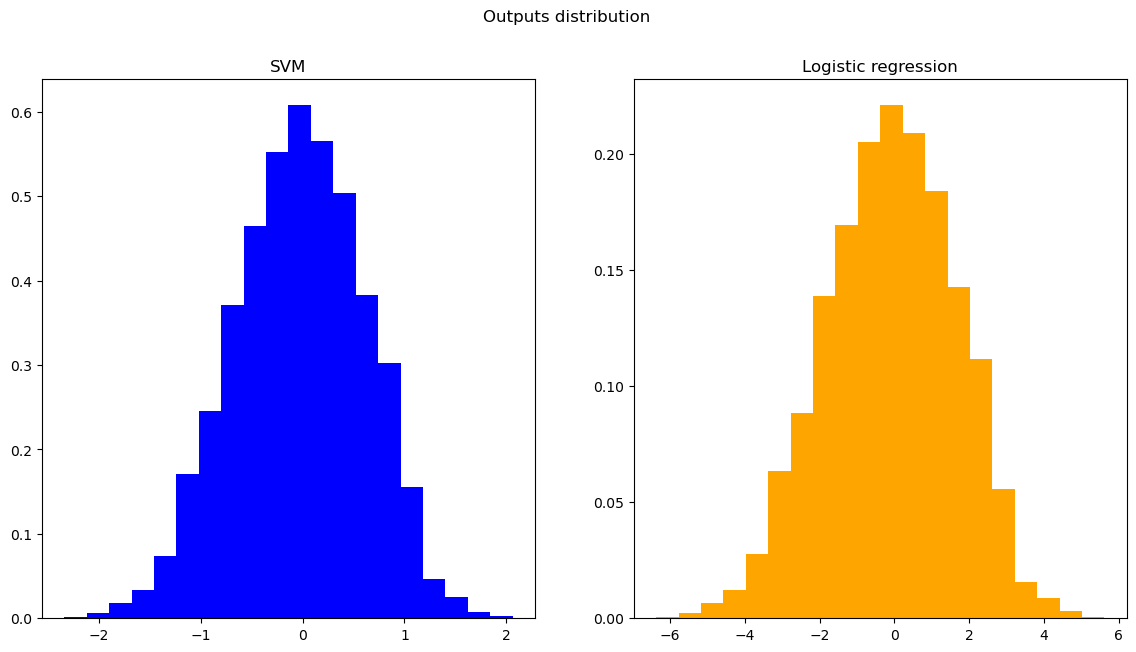

In [187]:
#посмотрим на распределение первоначальных ответов
svc_pred_1 = svc.decision_function(X_test)
lr_pred_1 = lr.decision_function(X_test)
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svc_pred_1, bins=20, color='blue', density='True')
axs[1].hist(lr_pred_1, bins=20, color='orange', density='True')

axs[0].set_title('SVM')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** 

Мы видим, что изначально классификаторы выдавали практически одинаковые распределения ответов, но когда мы перевели их в вероятности, уже получили разные графики. Следовательно, такое различие в распределениях можно обосновать тем, что мы использовали разные способы переводы предсказаний в интервал [0, 1].

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

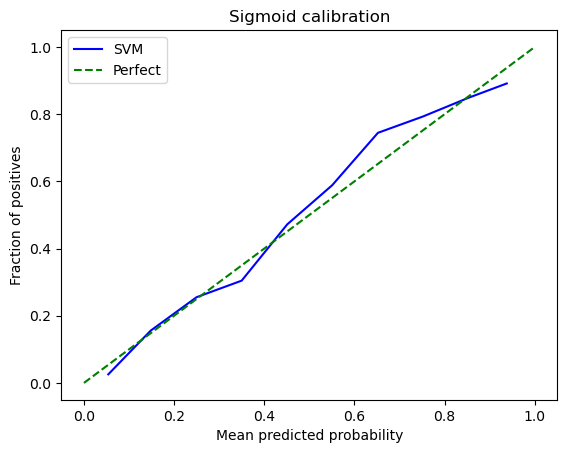

In [188]:
#воспользуемся разными методами калибровки
from sklearn.calibration import CalibratedClassifierCV
sigmoid_svc = CalibratedClassifierCV(svc, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
svc_true_prob, svc_pred_prob = calibration_curve(y_test, sigmoid_svc_pred, n_bins=10)
plt.plot(svc_pred_prob, svc_true_prob, label='SVM', color='blue')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Sigmoid calibration')
plt.legend()
plt.show()

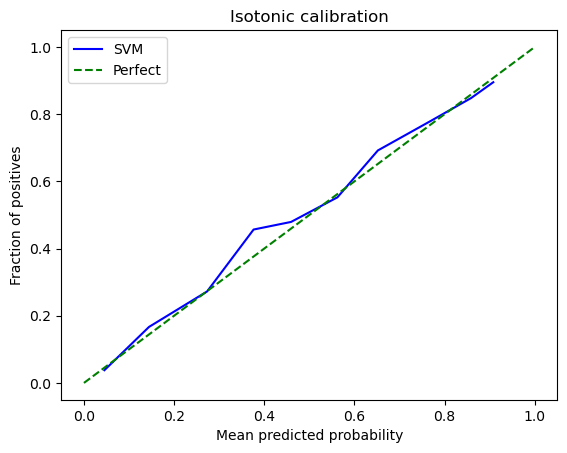

In [189]:
isotonic_svc = CalibratedClassifierCV(svc, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_svc_pred = isotonic_svc.predict_proba(X_test)[:, 1]
svc_true_prob, svc_pred_prob = calibration_curve(y_test, isotonic_svc_pred, n_bins=10)
plt.plot(svc_pred_prob, svc_true_prob, label='SVM', color='blue')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Isotonic calibration')
plt.legend()
plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** 

Мы видим, что оба варианта калибровки вероятностей дали значительное улучшение, теперь наши кривые близки к идеальной. Результаты получились даже лучше, чем были у логистической регрессии.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [190]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [191]:
df = pd.read_csv('bike_buyers.csv')

In [192]:
#Заменим пропуски категориальных переменных
#your code here
cat_features_mask = (df.dtypes == "object").values
df_cat =df[df.columns[cat_features_mask]].fillna('undefined')
df_real = df[df.columns[~cat_features_mask]]
df = pd.concat([df_real, df_cat], axis=1)

In [193]:
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые, признак ID не будем включать, 
#так как для каждого объекта он уникален и не влияет на предсказание
X_numerical = df[['Income', 'Children', 'Cars', 'Age']]
X_categorical = df[['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']]

В начале поработаем только с категориальными признаками

In [194]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [195]:
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [196]:
#your code here
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time
column_transformer = ColumnTransformer([
    ('OE', OrdinalEncoder(), categorical)
])

pipeline = Pipeline(steps=[
    ('oe', column_transformer),
    ('regression', LogisticRegression())
])
start = time.time()
model_1 = pipeline.fit(X_train, y_train)
end = time.time()
t = end-start
y_pred = model_1.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
df_enc = pd.DataFrame(columns=['AUC_PR', 'time'])
df_enc.loc['Ordinal Encoder'] = [
      auc(recall, precision), t]
df_enc

,AUC_PR,time
Ordinal Encoder,0.578944,0.015002


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [197]:
#your code here
from sklearn.preprocessing import OneHotEncoder
column_transformer = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore"), categorical)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('regression', LogisticRegression())
])
start = time.time()
model_2 = pipeline.fit(X_train, y_train)
end = time.time()
t = end-start
y_pred = model_2.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr_ohe = auc(recall, precision)
df_enc.loc['One-hot Encoder'] = [
      auc(recall, precision), t]
df_enc

,AUC_PR,time
Ordinal Encoder,0.578944,0.015002
One-hot Encoder,0.661865,0.027006


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

код для функции взят отсюда:
https://igorasic.blogspot.com/2019/04/mean-target-encoding.html

In [198]:
test = X_test.copy ()

In [199]:
D = pd.concat([X_train, y_train.to_frame()], axis=1)
start = time.time()
for i in categorical:
    mean_enc = D.groupby(i)['Purchased Bike'].mean()
    D[i] = D[i].map(mean_enc)
    dic = dict(mean_enc)
    for j in dic:
        test[i][test[i] == j] = dic[j]
train = D.iloc[:, :-1]
model_3 = LogisticRegression()
model_3.fit(train, y_train)
end = time.time()
t = end-start
y_pred = model_3.decision_function(test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
df_enc.loc['Mean target Encoder'] = [
      auc(recall, precision), t]
df_enc

,AUC_PR,time
Ordinal Encoder,0.578944,0.015002
One-hot Encoder,0.661865,0.027006
Mean target Encoder,0.652694,0.076018


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

код трансформера: https://brendanhasz.github.io/2019/03/04/target-encoding.html

In [200]:
#your code here
from sklearn.base import BaseEstimator, TransformerMixin
class TargetEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols=None):

        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        self.maps = dict() 
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):

        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        
        return self.fit(X, y).transform(X, y)

In [201]:
column_transformer = ColumnTransformer([
    ('MTE', TargetEncoder(), categorical)
])

pipeline = Pipeline(steps=[
    ('mte', column_transformer),
    ('regression', LogisticRegression())
])
start = time.time()
model_4 = pipeline.fit(X_train, y_train)
end = time.time()
t = end-start
y_pred = model_4.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr_mean = auc(recall, precision)
df_enc.loc['Mean target transformer'] = [
      auc(recall, precision), t]
df_enc

,AUC_PR,time
Ordinal Encoder,0.578944,0.015002
One-hot Encoder,0.661865,0.027006
Mean target Encoder,0.652694,0.076018
Mean target transformer,0.652694,0.032008


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [202]:
#your code here
class TargetEncoder_noise(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols=None, mu =0, sigma = 0.001):

        if isinstance(cols, str):
            self.cols = [cols]
            self.mu = mu
            self.sigma = sigma
        else:
            self.cols = cols
            self.mu = mu
            self.sigma = sigma
        
        
    def fit(self, X, y):
        
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        self.maps = dict() 
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):

        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target + np.random.normal(loc = self.mu, scale = self.sigma)
#             vals += np.random.normal(loc = 5, scale = 0.001, size = X.shape[0])
#                 np.random.poisson(lam=15)
#                 np.random.normal(loc = -2, scale = 0.001)
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        
        return self.fit(X, y).transform(X, y)

In [203]:
E = np.logspace(-5, 2, num = 10)
D = np.logspace(-5, 2, num = 10)
T = []
AUC_PR = []
for i in E:
    for j in D:
        column_transformer = ColumnTransformer([
        ('NOISE', TargetEncoder_noise(mu = i, sigma = j), categorical)
        ])

        pipeline = Pipeline(steps=[
        ('noise', column_transformer),
        ('regression', LogisticRegression())
        ])
        start = time.time()
        model_5 = pipeline.fit(X_train, y_train)
        end = time.time()
        t = end-start
        y_pred = model_5.decision_function(X_test)
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        auc_pr = auc(recall, precision)
        if auc_pr > auc_pr_mean:
            T.append(t)
            AUC_PR.append(auc_pr)
max_value = max(AUC_PR)
best_time = T[AUC_PR.index(max_value)]
df_enc.loc['Mean target noise'] = [
      max_value, best_time]
df_enc

,AUC_PR,time
Ordinal Encoder,0.578944,0.015002
One-hot Encoder,0.661865,0.027006
Mean target Encoder,0.652694,0.076018
Mean target transformer,0.652694,0.032008
Mean target noise,0.666520,0.034024


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:**

Да, добавление шума помогло, так как изначально при применении Mean target encoding у нас происходит утечка целевой переменной в обучающую выборку. Но после добавления шума эта проблема была решена.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [204]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [205]:
#your code here
class TargetEncoder_smooth(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols=None, c = 10):

        if isinstance(cols, str):
            self.cols = [cols]
            self.c = c
        else:
            self.cols = cols
            self.c = c
        
        
    def fit(self, X, y):
        
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        self.maps = dict()
        self.global_mean = y.mean()
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
#                 tmap[unique] = y[X[col]==unique].mean()
                  a = y[X[col]==unique].sum() + self.c*self.global_mean
                  b = len(y[X[col]==unique]) + self.c
                  tmap[unique] = a/b
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):

        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        
        return self.fit(X, y).transform(X, y)

In [206]:
T = []
AUC_PR = []
for i in range (-10, 10, 3):
    column_transformer = ColumnTransformer([
       ('SMOOTH', TargetEncoder_smooth(c = i), categorical)
       ])

    pipeline = Pipeline(steps=[
       ('smooth', column_transformer),
       ('regression', LogisticRegression())
       ])
    start = time.time()
    model_6 = pipeline.fit(X_train, y_train)
    end = time.time()
    t = end-start
    y_pred = model_6.decision_function(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_pr_smooth = auc(recall, precision)
    if auc_pr_smooth > auc_pr_ohe:
        T.append(t)
        AUC_PR.append(auc_pr_smooth)
max_value = max(AUC_PR)
best_time = T[AUC_PR.index(max_value)]
df_enc.loc['Mean target smooth'] = [
            max_value, best_time]
df_enc

,AUC_PR,time
Ordinal Encoder,0.578944,0.015002
One-hot Encoder,0.661865,0.027006
Mean target Encoder,0.652694,0.076018
Mean target transformer,0.652694,0.032008
Mean target noise,0.666520,0.034024
Mean target smooth,0.694688,0.030988


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [207]:
#your code here
from sklearn.impute import SimpleImputer
X.drop('ID', axis= 1 , inplace= True )
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, random_state=777, stratify=y)

X_train.index = list(range(X_train.shape[0]))
X_test.index = list(range(X_test.shape[0]))

In [208]:
y_train.index = list(range(X_train.shape[0]))
y_test.index = list(range(X_test.shape[0]))

In [209]:
cat_features_mask = (X_train.dtypes == "object").values
X_real = X_train[X_train.columns[~cat_features_mask]]
mis_replacer = SimpleImputer(strategy="mean")
X_no_mis_real = pd.DataFrame(
        data=mis_replacer.fit_transform(X_real), columns=X_real.columns)
X_cat = X_train[X_train.columns[cat_features_mask]]
X_train_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1)

In [210]:
cat_features_mask = (X_test.dtypes == "object").values
X_real1 = X_test[X_test.columns[~cat_features_mask]]
mis_replacer = SimpleImputer(strategy="mean")
mis_replacer.fit(X_real)
X_no_mis_real = pd.DataFrame(
        data=mis_replacer.transform(X_real1), columns=X_real1.columns)
X_cat = X_test[X_test.columns[cat_features_mask]]
X_test_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1)

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [211]:
numerical = ['Income', 'Children', 'Cars', 'Age']
for i in numerical:
    print(i, ' unique values: ', len(X[i].unique()))

Income  unique values:  17
Children  unique values:  7
Cars  unique values:  6
Age  unique values:  54


Применять One-hot кодирование будет излишним, так как некоторые признаки имеют слишком много уникальных значений (например, доход и возраст), поэтому после One-hot кодирования количество признаков слишком сильно увеличится.

In [212]:
#посмотрим на модель, если оставить все признаки, как есть
from sklearn.preprocessing import StandardScaler
numerical = ['Income', 'Children', 'Cars', 'Age']
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
column_transformer = ColumnTransformer([
       ('mean target', TargetEncoder_smooth(c = -10), categorical),
       ('scaling', StandardScaler(), numerical)])

pipeline = Pipeline(steps=[
       ('scale and encode', column_transformer),
       ('regression', LogisticRegression())])
model = pipeline.fit(X_train_no_mis, y_train)
y_pred = model.decision_function(X_test_no_mis)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
df_res = pd.DataFrame(columns=['AUC_PR'])
df_res.loc['Initial model'] = [
      auc(recall, precision)]

In [213]:
#сделаем все признаки категориальными
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 
               'Region', 'Income', 'Children', 'Cars', 'Age']

column_transformer = ColumnTransformer([
       ('mean target', TargetEncoder_smooth(c = -10), categorical)])

pipeline = Pipeline(steps=[
       ('scale and encode', column_transformer),
       ('regression', LogisticRegression())])
model = pipeline.fit(X_train_no_mis, y_train)
y_pred = model.decision_function(X_test_no_mis)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
df_res.loc['All categorical'] = [
      auc(recall, precision)]

In [214]:
#отнесем возраст к категориальным
numerical = ['Income', 'Children', 'Cars']
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region', 'Age']
column_transformer = ColumnTransformer([
       ('mean target', TargetEncoder_smooth(c = -10), categorical),
       ('scaling', StandardScaler(), numerical)])

pipeline = Pipeline(steps=[
       ('scale and encode', column_transformer),
       ('regression', LogisticRegression())])
model = pipeline.fit(X_train_no_mis, y_train)
y_pred = model.decision_function(X_test_no_mis)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
df_res.loc['Age - categorical'] = [
      auc(recall, precision)]

In [215]:
#отнесем машины к категориальным
numerical = ['Income', 'Children', 'Age']
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region', 'Cars']
column_transformer = ColumnTransformer([
       ('mean target', TargetEncoder_smooth(c = -10), categorical),
       ('scaling', StandardScaler(), numerical)])

pipeline = Pipeline(steps=[
       ('scale and encode', column_transformer),
       ('regression', LogisticRegression())])
model = pipeline.fit(X_train_no_mis, y_train)
y_pred = model.decision_function(X_test_no_mis)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
df_res.loc['Cars - categorical'] = [
      auc(recall, precision)]

In [216]:
#отнесем детей к категориальным
numerical = ['Income', 'Age', 'Cars']
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region', 'Children']
column_transformer = ColumnTransformer([
       ('mean target', TargetEncoder_smooth(c = -10), categorical),
       ('scaling', StandardScaler(), numerical)])

pipeline = Pipeline(steps=[
       ('scale and encode', column_transformer),
       ('regression', LogisticRegression())])
model = pipeline.fit(X_train_no_mis, y_train)
y_pred = model.decision_function(X_test_no_mis)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
df_res.loc['Children - categorical'] = [
      auc(recall, precision)]

In [217]:
#отнесем доход к категориальным
numerical = ['Age', 'Cars', 'Children']
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region', 'Income']
column_transformer = ColumnTransformer([
       ('mean target', TargetEncoder_smooth(c = -10), categorical),
       ('scaling', StandardScaler(), numerical)])

pipeline = Pipeline(steps=[
       ('scale and encode', column_transformer),
       ('regression', LogisticRegression())])
model = pipeline.fit(X_train_no_mis, y_train)
y_pred = model.decision_function(X_test_no_mis)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
df_res.loc['Income - categorical'] = [
      auc(recall, precision)]
df_res

,AUC_PR
Initial model,0.692533
All categorical,0.574761
Age - categorical,0.691581
Cars - categorical,0.692442
Children - categorical,0.692678
Income - categorical,0.445772


Можно заметить, что отнесение всех признаков к категориальным привело к ухудшению результатов. Признаки возраст, машины, дети можно отнести к категориальным, так как результат практически не изменился по сравнению с изначальной моделью. Признак доход не стоит относить к категориальным, так как в этом случае качество сильно падает.

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 

Главным преимуществом счетчиков является то, что они не приводят к увеличению количества признаков, количество признаков вообще не меняется. Но в то же самое времчя при использовании счетчиков происходит утнчка информации о целевой переменной, так как мы заменяем значения признаков на среднее значение целевой переменной. Эту проблему приходится решатать.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [218]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

In [219]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
89,43,Federal-gov,410867,Doctorate,16,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,1


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [220]:
#your code here
X = df.drop(columns=['income'])
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [221]:
print('Количество признаков до OHE: ', X_train.shape[1])

Количество признаков до OHE:  14


Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [222]:
#your code here
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
column_transformer = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore"), categorical)])
X_train_OHE = column_transformer.fit_transform(X_train)
X_test_OHE = column_transformer.transform(X_test)
print('Количество признаков после OHE: ', X_train_OHE.shape[1])
print('Количество новых признаков: ', (X_train_OHE.shape[1]-X_train.shape[1]))

Количество признаков после OHE:  102
Количество новых признаков:  88


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [223]:
#your code here
column_transformer = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore"), categorical)])
pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('regression', LogisticRegression())
])

model_lr = pipeline.fit(X_train, y_train)
y_pred = model_lr.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)

auc_pr_1 = auc(recall, precision)
df_res = pd.DataFrame(columns=['AUC_PR', 'Время отбора'])
df_res.loc['Not scaled model'] = [
      auc_pr_1, '-']
df_res

,AUC_PR,Время отбора
Not scaled model,0.685962,-


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



Идея сортировки: https://pythonhint.com/post/1147604920060603/logistic-regression-how-to-find-top-three-feature-that-have-highest-weights

In [224]:
#your code here
def sort_feat(coefs, X):
    sorted_indices = np.argsort(abs(coefs))[::-1]
    top_indices = sorted_indices[:40]
    top_feat = X[:, top_indices]
    return(top_feat)

In [225]:
coefficients = model_lr['regression'].coef_[0]

start = time.time()
X_train_sorted = sort_feat(coefficients, X_train_OHE)
X_test_sorted = sort_feat(coefficients, X_test_OHE)
end = time.time()

new_model_1 = LogisticRegression()
new_model_1.fit(X_train_sorted, y_train)

y_pred = new_model_1.decision_function(X_test_sorted)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr_2 = auc(recall, precision)
df_res.loc['Not scaled model 40 features'] = [
      auc_pr_2, end - start]
df_res

,AUC_PR,Время отбора
Not scaled model,0.685962,-
Not scaled model 40 features,0.661448,0.004


Изменилось ли качество? Как?

Качество стало немного ниже. Возможно, стоило взять побольше признаков.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [226]:
#your code here
column_transformer = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('SCALE', StandardScaler(), numerical)])
pipeline = Pipeline(steps=[
    ('ohe - scale', column_transformer),
    ('regression', LogisticRegression())
])

model_scaled = pipeline.fit(X_train, y_train)
y_pred = model_scaled.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr_3 = auc(recall, precision)

df_res.loc['Scaled model'] = [
      auc_pr_3, '-']
df_res

,AUC_PR,Время отбора
Not scaled model,0.685962,-
Not scaled model 40 features,0.661448,0.004
Scaled model,0.767120,-


После масштабирования сразу видно улучшение качества, попробуем снова отобрать признаки.

In [227]:
column_transformer = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('SCALE', StandardScaler(), numerical)])
start = time.time()
X_train_scaled = column_transformer.fit_transform(X_train)
X_test_scaled = column_transformer.transform(X_test)
coefficients = model_scaled['regression'].coef_[0]

start = time.time()
X_train_sorted = sort_feat(coefficients, X_train_scaled)
X_test_sorted = sort_feat(coefficients, X_test_scaled)
end = time.time()

new_model_2 = LogisticRegression()
new_model_2.fit(X_train_sorted, y_train)

y_pred = new_model_2.decision_function(X_test_sorted)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr_4 = auc(recall, precision)
df_res.loc['Scaled model 40 features'] = [
      auc_pr_4, end - start]
df_res

,AUC_PR,Время отбора
Not scaled model,0.685962,-
Not scaled model 40 features,0.661448,0.004
Scaled model,0.767120,-
Scaled model 40 features,0.738770,0.002018


Качество стало ниже. Возможно, следовало взять больше признаков.

In [228]:
#список лучших прзнаков
sorted_indices = np.argsort(abs(coefficients))[::-1]
top_indices = sorted_indices[:40]
top_indices

array([105,  26,  41,  27,  64,  29,  50,  37,  52,  30,  58,  66,  28,
        36,  61,  70,  62,  22,   8,  71,  40,  49, 104,  82,  43,  25,
        45,  90,  42,  13,   1,  87,  12,  53, 100,  68,  84,  72,  95,
        31], dtype=int64)

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [229]:
#your code here
features = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country']

column_transformer1 = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore"), categorical)])
column_transformer2 = StandardScaler(with_mean=False)
pipeline = Pipeline(steps=[
    ('ohe', column_transformer1),
    ('scale', column_transformer2),
    ('regression', LogisticRegression())
])
model_new = pipeline.fit(X_train, y_train)

y_pred = model_new.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr_5 = auc(recall, precision)
df_res.loc['All feartures scaled'] = [
      auc_pr_5, '-']
df_res

,AUC_PR,Время отбора
Not scaled model,0.685962,-
Not scaled model 40 features,0.661448,0.004
Scaled model,0.767120,-
Scaled model 40 features,0.738770,0.002018
All feartures scaled,0.684348,-


После стандартизации всех признаков качество упало, снова отберем лучшие.

In [230]:
column_transformer1 = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore"), categorical)])
column_transformer2 = StandardScaler(with_mean=False)

X_train_OHE = column_transformer1.fit_transform(X_train)
X_test_OHE = column_transformer1.transform(X_test)
X_train_final = column_transformer2.fit_transform(X_train_OHE)
X_test_final = column_transformer2.transform(X_test_OHE)
coefficients = model_new['regression'].coef_[0]

start = time.time()
X_train_sorted = sort_feat(coefficients, X_train_final)
X_test_sorted = sort_feat(coefficients, X_test_final)
end = time.time()

new_model_3 = LogisticRegression()
new_model_3.fit(X_train_sorted, y_train)

y_pred = new_model_3.decision_function(X_test_sorted)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr_6 = auc(recall, precision)
df_res.loc['All feartures scaled 40'] = [
      auc_pr_6, end - start]
df_res

,AUC_PR,Время отбора
Not scaled model,0.685962,-
Not scaled model 40 features,0.661448,0.004
Scaled model,0.767120,-
Scaled model 40 features,0.738770,0.002018
All feartures scaled,0.684348,-
All feartures scaled 40,0.679100,0.004


Видно, что после стандартизации всех признаков и их отбора качество осталось практически таким же, как у модели построенной на всех стандартизированных признаках, но оно все равно ниже, чем было у модели, для которой мы стандартизировали только числовые признаки.

In [231]:
sorted_indices = np.argsort(abs(coefficients))[::-1]
top_indices = sorted_indices[:40]
top_indices

array([29, 27, 50, 41, 58, 40, 22, 21, 36, 23, 20, 19, 10, 25, 18, 14,  9,
       52, 15, 30, 86, 38, 55, 37,  8, 88, 57, 48,  6, 64, 49, 13, 42, 39,
       99, 47, 12, 32,  7, 28], dtype=int64)

Также можно заметить, что совершенно изменился список лучших признаков. Именно поэтому качество так изменилось по сравнению с моделью, где использовалась стандартизация только числовых признаков.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [232]:
#your code here
column_transformer = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore", sparse = False), categorical),
    ('SCALE', StandardScaler(), numerical)])

X_train_scaled = column_transformer.fit_transform(X_train)
X_test_scaled = column_transformer.transform(X_test)

start = time.time()
t_res = []
num = X_train_scaled.shape[1]
for i in range(num):
        x = X_train_scaled[:, i].copy()
        numerator = abs(x[y_train == 1].mean() - x[y_train != 1].mean())
        n_1 = len(x[y_train == 1])
        n_0 = len(x[y_train != 1])
        var_1 = (x[y_train == 1].std())**2
        var_0 = (x[y_train != 1].std())**2
        denominator = np.sqrt((n_1*var_1+n_0*var_0)/(n_1+n_0))
        t_res.append(numerator/denominator)
end = time.time()

t_res = np.reshape(t_res, (len(t_res), ))
X_train_sorted = sort_feat(t_res, X_train_scaled)
X_test_sorted = sort_feat(t_res, X_test_scaled)
new_model_4 = LogisticRegression()
new_model_4.fit(X_train_sorted, y_train)

y_pred = new_model_4.decision_function(X_test_sorted)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr_4 = auc(recall, precision)
df_res.loc['Filter method'] = [
      auc_pr_4, end - start]
df_res      

,AUC_PR,Время отбора
Not scaled model,0.685962,-
Not scaled model 40 features,0.661448,0.004
Scaled model,0.767120,-
Scaled model 40 features,0.738770,0.002018
All feartures scaled,0.684348,-
All feartures scaled 40,0.679100,0.004
Filter method,0.762057,0.189039


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [233]:
#your code here
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)
column_transformer = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore", sparse = False), categorical),
    ('SCALE', StandardScaler(), numerical)])

X_train_scaled = column_transformer.fit_transform(X_train)
X_val_scaled = column_transformer.transform(X_val)
X_test_scaled = column_transformer.transform(X_test)

In [234]:
start = time.time()
features_num = X_train_scaled.shape[1]
features = set(range(0,features_num))
features_1 = set(range(0,features_num))
while features_num > 40:
    quality = []
    f = []
    for i in features_1:
        if i in features:
            indices = features - set([i])
            train = X_train_scaled[:, list(indices)]
            val = X_val_scaled[:, list(indices)]
            model = LogisticRegression()
            model.fit(train, y_train)
            y_pred = model.decision_function(val)
            precision, recall, _ = precision_recall_curve(y_val, y_pred)
            f.append(i)
            quality.append(auc(recall, precision))
    max_auc = max(quality)
    worst_feature = f[quality.index(max_auc)]
    features = features - set([worst_feature])
    features_num -= 1
end = time.time()

In [235]:
X_train_sorted = X_train_scaled[:, list(features)]
X_test_sorted = X_test_scaled[:, list(features)]
best_model = LogisticRegression()
best_model.fit(X_train_sorted, y_train)
y_pred = best_model.decision_function(X_test_sorted)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr_5 = auc(recall, precision)
t = end - start
df_res.loc['Метод исключения'] = [
      auc_pr_5, t]
df_res

,AUC_PR,Время отбора
Not scaled model,0.685962,-
Not scaled model 40 features,0.661448,0.004
Scaled model,0.767120,-
Scaled model 40 features,0.738770,0.002018
All feartures scaled,0.684348,-
All feartures scaled 40,0.679100,0.004
Filter method,0.762057,0.189039
Метод исключения,0.764370,2262.584835


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [236]:
#your code here
start = time.time()
features_num = 0
n = X_train_scaled.shape[1]
features = set([])
features_1 = set(range(0,n))
metrika = []
NUM = []
while features_num < 40:
    quality = []
    f = []
    for i in features_1:
        if i not in features:
            indices = features | set([i])
            train = X_train_scaled[:, list(indices)]
            val = X_val_scaled[:, list(indices)]
            model = LogisticRegression()
            model.fit(train, y_train)
            y_pred = model.decision_function(val)
            precision, recall, _ = precision_recall_curve(y_val, y_pred)
            f.append(i)
            quality.append(auc(recall, precision))
    max_auc = max(quality)
    best_feature = f[quality.index(max_auc)]
    features = features | set([best_feature])
    features_num += 1
    metrika.append(max_auc)
    NUM.append(features_num)
end = time.time()

In [237]:
X_train_sorted = X_train_scaled[:, list(features)]
X_test_sorted = X_test_scaled[:, list(features)]
best_model = LogisticRegression()
best_model.fit(X_train_sorted, y_train)
y_pred = best_model.decision_function(X_test_sorted)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr_6 = auc(recall, precision)
t = end - start
df_res.loc['Метод включения'] = [
      auc_pr_6, t]
df_res

,AUC_PR,Время отбора
Not scaled model,0.685962,-
Not scaled model 40 features,0.661448,0.004
Scaled model,0.767120,-
Scaled model 40 features,0.738770,0.002018
All feartures scaled,0.684348,-
All feartures scaled 40,0.679100,0.004
Filter method,0.762057,0.189039
Метод исключения,0.764370,2262.584835
Метод включения,0.764597,468.256384


Text(0.5, 1.0, 'График изменения AUC-PR в зависимоти от количества признаков ')

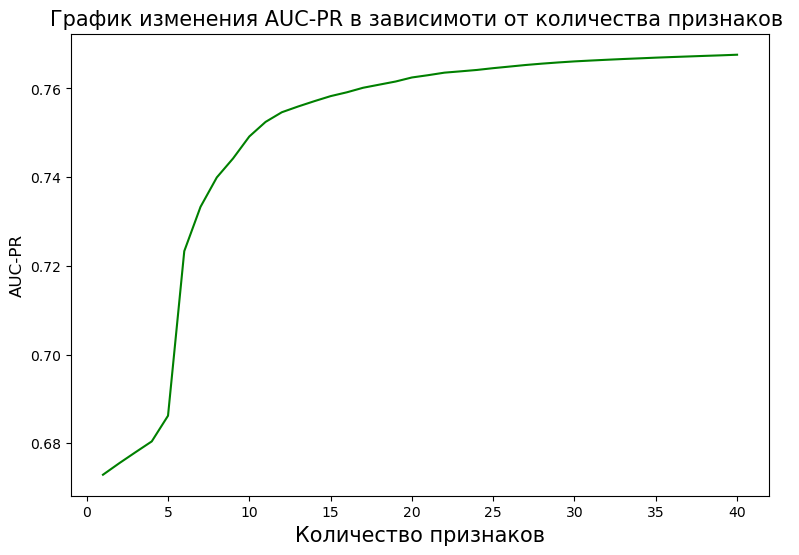

In [238]:
#посмотрим, как менялось качество в зависимости от количества признаков
plt.figure(figsize=(9,6))
plt.plot(NUM, metrika, color = 'green')
plt.xlabel('Количество признаков', fontsize = 15)
plt.ylabel('AUC-PR', fontsize = 12)
plt.title('График изменения AUC-PR в зависимоти от количества признаков ', fontsize = 15)

На графике видно, что с добавлением каждого нового признака качество модели растет, поэтому нельзя выделить порог, при котором добавление новых признаков ухудшает качество.

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

Главным преимуществом embedded method является то, что он занимает самое маленькое количество времени, но в то же самое время нам приходится дважду обучить модель, сначала на всех признаках, потом на отобранных. Этот метод показал неплохие результаты после стандартизации, но они не являются лучшими. Применение метода фильтрации показало самое высокое качество ( на равне с методами обертки), но здесь проблема в том, что необходимо считать t-статистику покаждому признаку, это занимает больше времени, чем embedded method, но значительно меньше, чем методы-обертки. Методы обертки оказались самыми затратными по времени. Оба метода показали высокое значение метрики качества, но из-за того, что на его реализацию требуется много времени, лучше выбрать метод фильтрации для отбора признаков.

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [433]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# !unzip bank-additional.zip
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [434]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [435]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [436]:
# your code here
from sklearn.model_selection import KFold
folds = KFold(n_splits=5, shuffle=True, random_state=500)
split = folds.split(X)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [437]:
# your code here
categorical = ['job', 'marital', 'education', 'default', 'housing', 'contact', 'month', 'day_of_week', 'poutcome', 'loan']
numerical = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
                  'cons.conf.idx', 'euribor3m', 'nr.employed']

In [438]:
column_transformer = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('SCALE', StandardScaler(), numerical)])

pipeline = Pipeline(steps=[
    ('ohe - scale', column_transformer),
    ('regression', LogisticRegression())
])

In [439]:
predictions = []
answers = []
for train, test in folds.split(X):
    X_train = X.loc[train, :]
    X_test = X.loc[test, :]
    y_train = y[train]
    y_test = y[test]
    
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    predictions.append(y_pred)
    answers.append(y_test)

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [440]:
# your code here
revenue = []
costs = []
for i in range(5):
    rev = 10 * len(predictions[i][(predictions[i] == True) & (answers[i] == True)])
    c = 1 * len(predictions[i][predictions[i] == True])
    revenue.append(rev)
    costs.append(c)

In [441]:
print('Средняя выручка: ', np.array(revenue).mean())
print('СКО выручки: ', np.array(revenue).std())
print('Средние издержки: ', np.array(costs).mean())
print('СКО издержек: ', np.array(costs).std())
print('Средняя прибыль: ', (np.array(revenue) - np.array(costs)).mean())
print('СКО прибыли: ', (np.array(revenue) - np.array(costs)).std())

Средняя выручка:  2128.0
СКО выручки:  102.64501936285072
Средние издержки:  323.6
СКО издержек:  8.01498596380555
Средняя прибыль:  1804.4
СКО прибыли:  104.56500370582884


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [459]:
#your code here
revenue_1 = []
costs_1 = []
for i in range(5):
    rev = sum(np.random.uniform(0,20,(predictions[i][(predictions[i] == True) & (answers[i] == True)]).shape))
    c = 1 * len(predictions[i][predictions[i] == True])
    revenue_1.append(rev)
    costs_1.append(c)

In [460]:
print('Средняя выручка: ', np.array(revenue_1).mean())
print('СКО выручки: ', np.array(revenue_1).std())
print('Средние издержки: ', np.array(costs_1).mean())
print('СКО издержек: ', np.array(costs_1).std())
print('Средняя прибыль: ', (np.array(revenue_1) - np.array(costs_1)).mean())
print('СКО прибыли: ', (np.array(revenue_1) - np.array(costs_1)).std())

Средняя выручка:  2111.6659256443936
СКО выручки:  164.39541262415577
Средние издержки:  323.6
СКО издержек:  8.01498596380555
Средняя прибыль:  1788.0659256443935
СКО прибыли:  165.83650906320224


Мы видим, что средняя выручка изменилась, она стала немного меньше. А вот СКО выручки увеличился, вероятно, потому что новые значения выручки для каждого их фолдов имеют большее отклонение от математического ожидания. Прибыль также изменилась, так как является разностью выручки и издержек.

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [461]:
#your code here
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def custom_loss_function(test, pred):
    rev = sum(np.random.uniform(0,20,(pred[(pred == True) & (test == True)]).shape))
    cost = len(pred[pred == True])
    return (rev-cost)

In [462]:
column_transformer = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('SCALE', StandardScaler(), numerical)])

pipeline = Pipeline(steps=[
    ('ohe - scale', column_transformer),
    ('regression', LogisticRegression())
])

In [463]:
C = np.logspace(-4, 2, 30)
searcher = GridSearchCV(pipeline, [{'regression__C': C}],
                        scoring=make_scorer(custom_loss_function, greater_is_better=True), cv=folds)
searcher.fit(X, y)
best_C = searcher.best_params_["regression__C"]
print("Best C = %.4f" % best_C)

Best C = 0.8532


Text(0.5, 1.0, 'График изменения ожидаемой прибыли в зависимости от коэффициента')

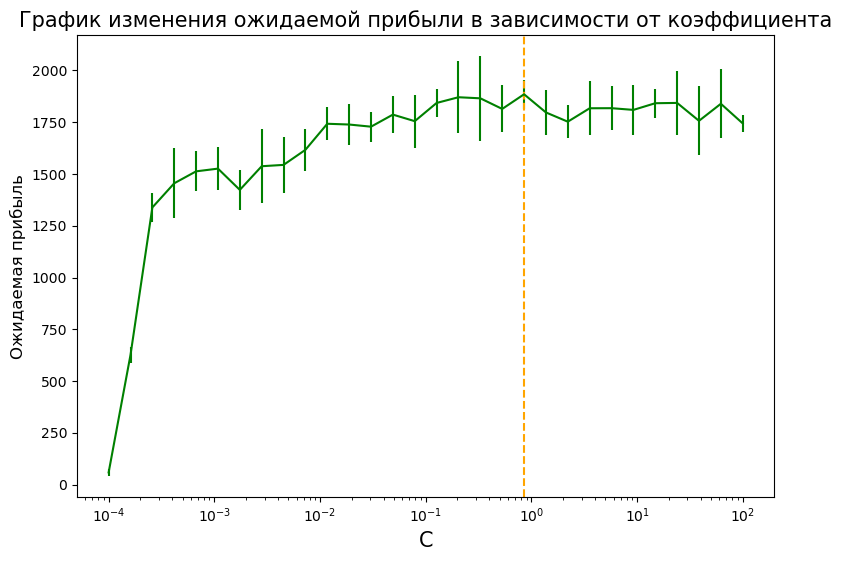

In [464]:
plt.figure(figsize=(9,6))
plt.errorbar(x=C, y=searcher.cv_results_["mean_test_score"], yerr=searcher.cv_results_['std_test_score'], color = 'green')
plt.xlabel('C', fontsize = 15)
plt.ylabel('Ожидаемая прибыль', fontsize = 12)
plt.xscale("log")
plt.axvline(x=best_C, linestyle ="--", c='orange')
plt.title('График изменения ожидаемой прибыли в зависимости от коэффициента', fontsize = 15)

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [465]:
#your code here
def find_C(X_train, y_train):
    C = np.logspace(-4, 2, 30)
    searcher = GridSearchCV(pipeline, [{'regression__C': C}],
                        scoring=make_scorer(custom_loss_function, greater_is_better=True), cv=folds)
    searcher.fit(X_train, y_train)
    best_C = searcher.best_params_["regression__C"]
    print("Best C = %.4f" % best_C)
    return(best_C)

In [466]:
all_C = []
for i in range(10):
    all_C.append(find_C(X, y))

Best C = 1.3738
Best C = 23.9503
Best C = 62.1017
Best C = 5.7362
Best C = 0.1269
Best C = 38.5662
Best C = 2.2122
Best C = 1.3738
Best C = 0.3290
Best C = 2.2122


Text(0.5, 1.0, 'График изменения параметра C')

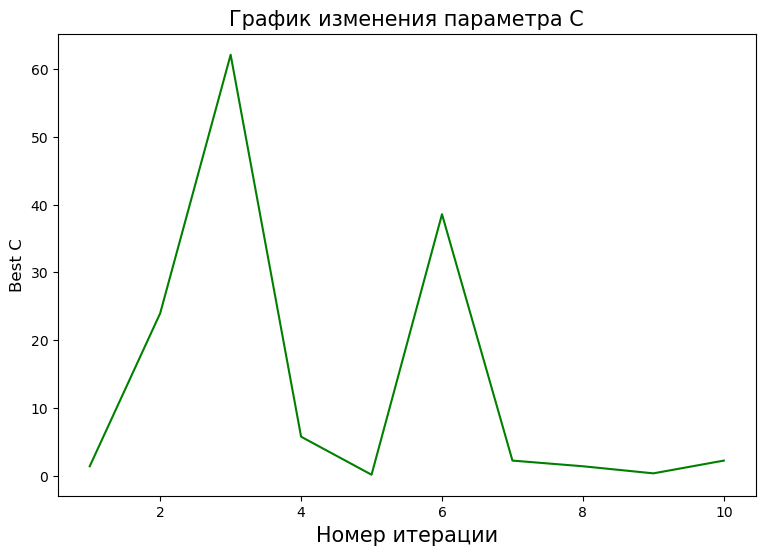

In [467]:
ze = list(range(1,11))
plt.figure(figsize=(9,6))
plt.plot(ze, all_C, color = 'green')
plt.xlabel('Номер итерации', fontsize = 15)
plt.ylabel('Best C', fontsize = 12)
plt.title('График изменения параметра C', fontsize = 15)

На графике видно, что нам не удается найти один и тот же коэффициент C, также нельзя ничего сказать о закономерности результатов. Это объясняется тем, что теперь прибыль - равномерно распределенная случайная величина.

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ 



Если мы точно получаем 10 в случае правильного определения положительно класса, то нам важнее recall, так как он показывает, насколько модель покрывает положительный класс. Мы хотели бы покрыть весь положительный класс, так как тогда наша выручка будет максимальна. Precision показывает, насколько можно доверять модели, если она выдает положительный класс, но даже если precision будет низкий, то наша потери в случае ошибки будут всего 1.

> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [468]:
column_transformer = ColumnTransformer([
    ('OHE', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('SCALE', StandardScaler(), numerical)])

pipeline = Pipeline(steps=[
    ('ohe - scale', column_transformer),
    ('regression', LogisticRegression())
])

In [469]:
#your code here
thresholds = np.arange(0, 1, 0.01)
INCOME = []
STD = []

for i in thresholds:
    income = []
    
    for train, test in folds.split(X):
        X_train = X.loc[train, :]
        X_test = X.loc[test, :]
        y_train = y[train]
        y_test = y[test]
        
        model = pipeline.fit(X_train, y_train)
        ans = model.predict_proba(X_test)[:, 1]
        y_pred = (i < ans)
        
        inc = custom_loss_function(y_test, y_pred)
        income.append(inc)
        
    mean_income = np.array(income).mean()
    income_std = np.array(income).std()
    INCOME.append(mean_income)
    STD.append(income_std)


max_value = max(INCOME)
best_threshold = thresholds[INCOME.index(max_value)]
print("Best_threshold = ", best_threshold)

Best_threshold =  0.12


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




Text(0.5, 1.0, 'График изменения средней прибыли в зависимости от порога')

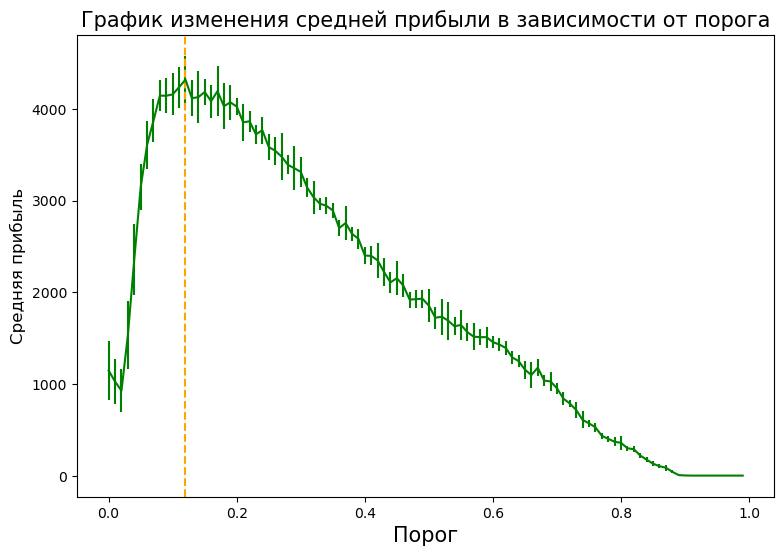

In [470]:
#your code here
plt.figure(figsize=(9,6))
plt.errorbar(x=thresholds, y= INCOME, yerr=STD, color = 'green')
plt.xlabel('Порог', fontsize = 15)
plt.ylabel('Средняя прибыль', fontsize = 12)
plt.axvline(x=best_threshold, linestyle ="--", c='orange')
plt.title('График изменения средней прибыли в зависимости от порога', fontsize = 15)

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [471]:
for j in range(3):
    thresholds = np.arange(0, 1, 0.01)
    INCOME = []
    STD = []

    for i in thresholds:
        income = []
    
        for train, test in folds.split(X):
            X_train = X.loc[train, :]
            X_test = X.loc[test, :]
            y_train = y[train]
            y_test = y[test]
        
            model = pipeline.fit(X_train, y_train)
            ans = model.predict_proba(X_test)[:, 1]
            y_pred = (i < ans)
        
            inc = custom_loss_function(y_test, y_pred)
            income.append(inc)
        
        mean_income = np.array(income).mean()
        income_std = np.array(income).std()
        INCOME.append(mean_income)
        STD.append(income_std)


    max_value = max(INCOME)
    print("Best_threshold = ", thresholds[INCOME.index(max_value)])

Best_threshold =  0.1
Best_threshold =  0.12
Best_threshold =  0.18


__Ответ:__ 

Вероятно, при значениях порога, лежащих в дипазоне от 0.1 до 0.2, мы получаем максимально большое количество верно спрогнозированных положительных классов. Тогда мы совершаем наибольшее количество верных звонков, то есть количество согласившихся большое и выручка растет.

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [472]:
#your code here
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision = []
recall = []
income = []
for train, test in folds.split(X):
    X_train = X.loc[train, :]
    X_test = X.loc[test, :]
    y_train = y[train]
    y_test = y[test]
        
    model = pipeline.fit(X_train, y_train)
    ans = model.predict_proba(X_test)[:, 1]
    y_pred = (best_threshold < ans)
    
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    
    inc = custom_loss_function(y_test, y_pred)
    income.append(inc)

print('Precision = ', np.array(precision).mean()) 
print('Recall = ', np.array(recall).mean())
print('Income STD  = ', np.array(income).std())

Precision =  0.3545526623744593
Recall =  0.6255060060426254
Income STD  =  196.76389006653736


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [474]:
#your code here
thresholds = np.arange(0, 1, 0.01)

PR = []
RC = []


for i in thresholds:
    precision = []
    recall = []
    
    for train, test in folds.split(X):
        X_train = X.loc[train, :]
        X_test = X.loc[test, :]
        y_train = y[train]
        y_test = y[test]
        
        model = pipeline.fit(X_train, y_train)
        ans = model.predict_proba(X_test)[:, 1]
        y_pred = (i < ans)
        
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
     
    
    R = np.array(recall).mean()
    P = np.array(precision).mean()
    
    if R >= 0.5:
        PR.append(P)
        RC.append((R-0.5)/0.5)    #сразу будем делать MinMax Scaling recall
    

In [477]:
auc(RC, PR)

0.24594981767946283

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ 

Мюсли с молоком )))